## Data and equation solving

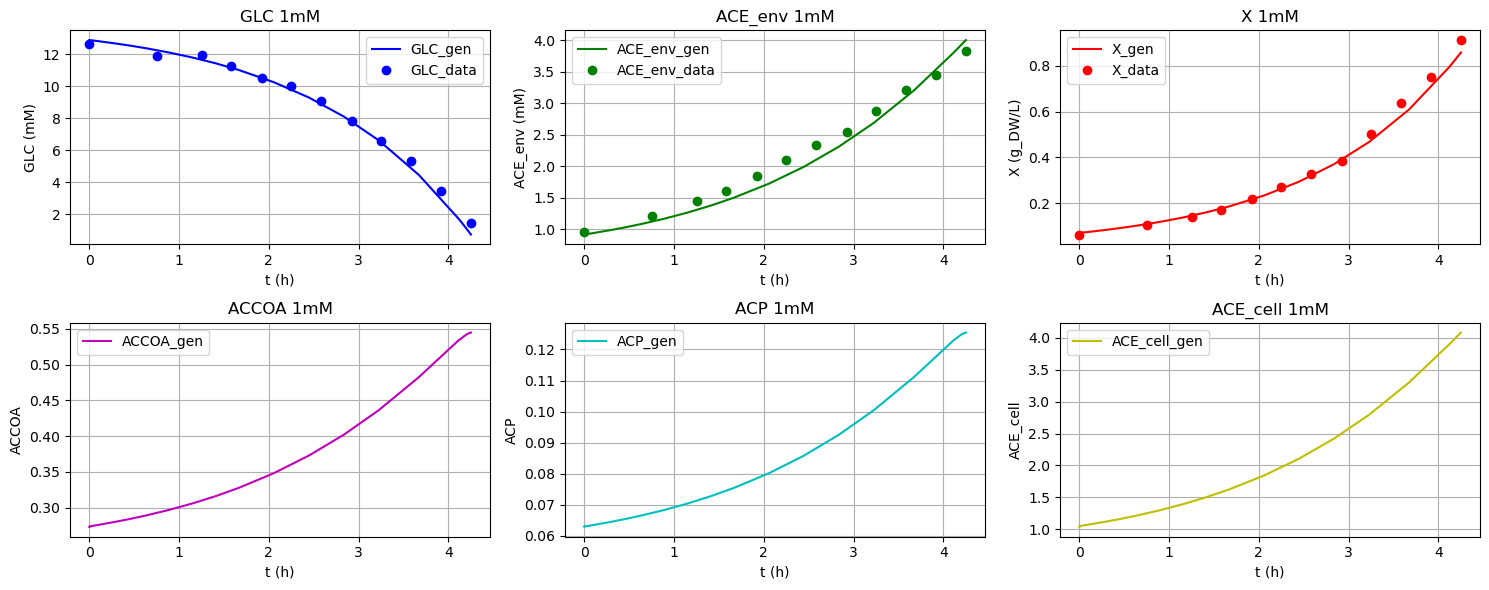

In [1]:
# Solving the ODE system for 1mM
from Millard_dicts import DICT, ranges_dict, standard_deviations_dict
from scipy.integrate import solve_ivp
from deriv_equations_Millard import deriv_Millard
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

# Initial conditions used by Millard
GLC_1_0 = 12.89999655
ACE_env_1_0 = 0.9200020244
X_1_0 = 0.06999993881

# Eyeball estimated initial conditions
ACCOA_1_0 = 0.27305
ACP_1_0 = 0.063
ACE_cell_1_0 = 1.035

# Initial conditions vector
y_1_0 = [GLC_1_0, ACE_env_1_0, X_1_0, ACCOA_1_0, ACP_1_0, ACE_cell_1_0] 

res = solve_ivp(fun=deriv_Millard,
                t_span=(0,4.25),
                y0=y_1_0,
                method='LSODA',
                args=(DICT,))

GLC, ACE_env, X, ACCOA, ACP, ACE_cell = res.y

# Load experimental data 
data_1 = genfromtxt('data_1mM.csv', delimiter=',')

# Constructing the figure

fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(res.t, GLC, label='GLC_gen', color='b')
axs[0,0].plot(data_1[1:, 0], data_1[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t (h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(res.t, ACE_env, label='ACE_env_gen', color='g')
axs[0,1].plot(data_1[1:, 0], data_1[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(res.t, X,label='X_gen', color='r')
axs[0,2].plot(data_1[1:, 0], data_1[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(res.t, ACCOA, label='ACCOA_gen', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(res.t, ACP, label='ACP_gen', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(res.t, ACE_cell,label='ACE_cell_gen', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

In [2]:
# Export generated data from ODE solving
generated_Millard_data = np.asarray([res.t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]) 
np.savetxt("generated_Millard_data.csv", generated_Millard_data, delimiter=",")

In [3]:
#load generated data
ode_data_1 = genfromtxt('generated_Millard_data.csv', delimiter=',') # in the form [t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]

## Neural Network Training for initial ACE 1mM

In [4]:
# Training parameters 
import torch
import torch.optim as optim

epoch_number = 150000

# Optimizer parameters
optimizer_type = optim.Adam
learning_rate = 1e-4
optimizer_hyperparameters = {"lr":learning_rate}

# Scheduler parameters (unused right now)
scheduler_type = optim.lr_scheduler.CyclicLR
base_lr = 1e-4
max_lr = 1e-4
step_size_up = 100
scale_mode = "exp_range"
gamma = 0.999
cycle_momentum = False
scheduler_hyperparameters = {"base_lr":base_lr, 
                             "max_lr":max_lr, 
                             "step_size_up":step_size_up,
                             "scale_mode":scale_mode,
                             "gamma":gamma,
                             "cycle_momentum":cycle_momentum}

# Loss calculation method
multiple_loss_method = "my_weights"

In [5]:
# Setting variables (known and unknown), parameters, parameters ranges, constants, weights 
import random
from tools import random_ranges, ssr_error

random.seed(42)

observables = ["GLC","ACE_env","X","ACCOA","ACP","ACE_cell"]
variable_data = {v : ode_data_1[i+1] for i,v in enumerate(observables)}
variable_no_data  = {}
# variable_no_data  = {"ACCOA":None,"ACP":None,"ACE_cell":None}

data_t = res.t

residual_weights=[1e-4,1e-1,1e-1,1e-14,1e-15,1e-8]

"""parameter_names = []
for key in DICT.keys():
    if DICT[key] != 0:
        parameter_names.append(key)"""

parameter_names = ["v_max_AckA", "v_max_Pta", "v_max_glycolysis", "Ki_ACE_glycolysis", "Km_ACCOA_TCA_cycle", "v_max_TCA_cycle", "Ki_ACE_TCA_cycle", "Y", "v_max_acetate_exchange", "Km_ACE_acetate_exchange"]

# Creating the ranges: using random_ranges or the ranges provided by Millard
ranges = random_ranges([DICT[key] for key in parameter_names],scale=20)
for i in range(len(parameter_names)):
    if parameter_names[i] in ranges_dict:
        ranges[i]=ranges_dict[parameter_names[i]]

constants_dict = DICT

In [6]:
# Create the PINN
from pinn import Pinn
from deriv_equations_Millard import ODE_residual_dict_Millard

torch.manual_seed(42)

pinn_cell = Pinn(ode_residual_dict=ODE_residual_dict_Millard,
                 ranges=ranges,
                 data_t=data_t,
                 variables_data=variable_data,
                 variables_no_data=variable_no_data,
                 parameter_names=parameter_names,
                 optimizer_type=optimizer_type,
                 optimizer_hyperparameters=optimizer_hyperparameters,
                 scheduler_type=scheduler_type,
                 scheduler_hyperparameters=scheduler_hyperparameters,
                 constants_dict=constants_dict,
                 multi_loss_method=multiple_loss_method,
                 residual_weights=residual_weights,
                 )

In [7]:
# Training
r2_store, pred_variables, losses, variable_fit_losses, residual_losses, learned_parameters, learning_rates = pinn_cell.train(epoch_number)
GLC_pred, ACE_env_pred, X_pred, ACCOA_pred, ACP_pred, ACE_cell_pred  = pred_variables

Training the neural network: 100%|████████████████████████████████████████████████████████████████████████████| 150000/150000 [36:51<00:00, 67.84it/s]


## Assessment

In [8]:
save_fig_choice = False
path_to_save = 'enter_path'

# save_fig_choice = True
# path_to_save = './test/'


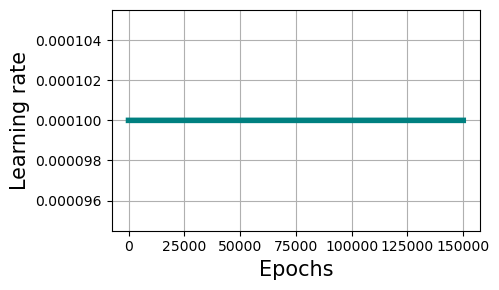

In [9]:
# Print and Plot learning rate
plt.figure(figsize=(5,3))
plt.plot(learning_rates[0:], color = 'teal',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Learning rate',fontsize=15)

plt.tight_layout()

plt.show()

Loss:  0.00071143


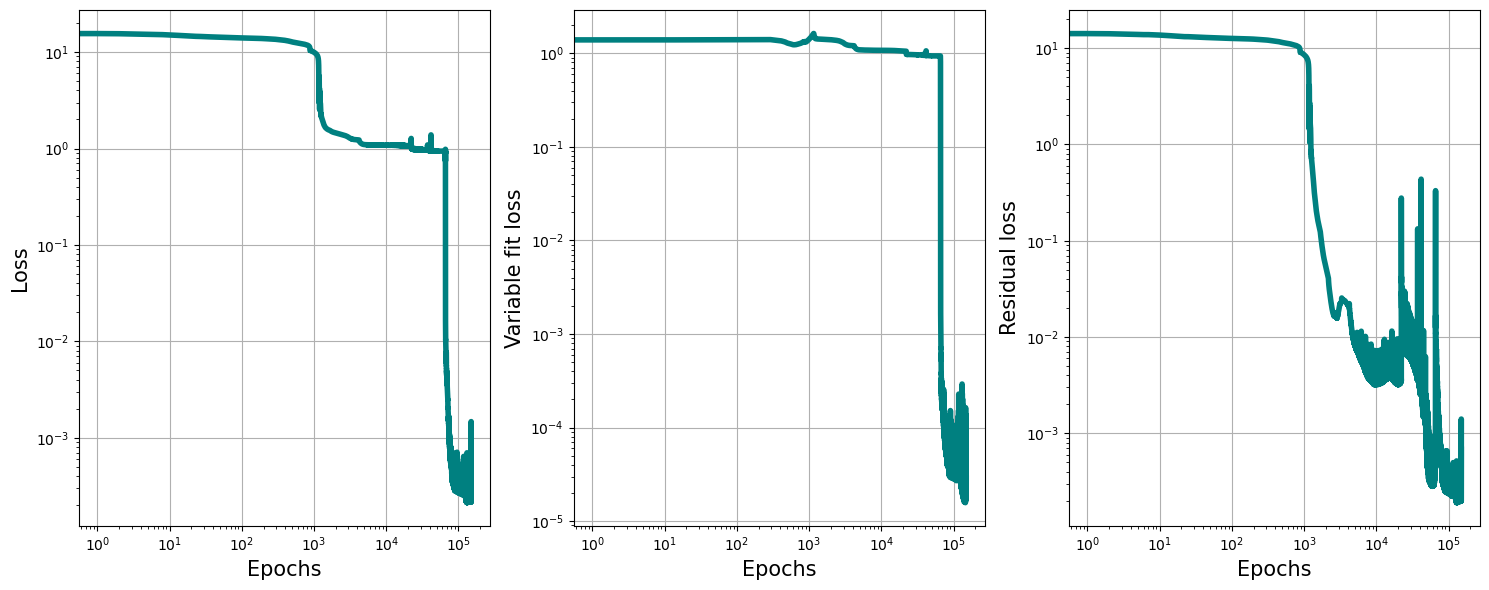

In [10]:
# Print and Plot Losses
print("Loss: ","%.5g" % losses[-1])

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].plot(losses[0:], color = 'teal',linewidth=4)
axs[0].grid(True)
axs[0].set_xlabel('Epochs',fontsize=15)
axs[0].set_ylabel('Loss',fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].plot(variable_fit_losses[0:], color = 'teal',linewidth=4)
axs[1].grid(True)
axs[1].set_xlabel('Epochs',fontsize=15)
axs[1].set_ylabel('Variable fit loss',fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].plot(residual_losses[0:], color = 'teal',linewidth=4)
axs[2].grid(True)
axs[2].set_xlabel('Epochs',fontsize=15)
axs[2].set_ylabel('Residual loss',fontsize=15)
axs[2].set_xscale('log')
axs[2].set_yscale('log')



plt.tight_layout()

fig_name = 'loss_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

r2 : 12.649


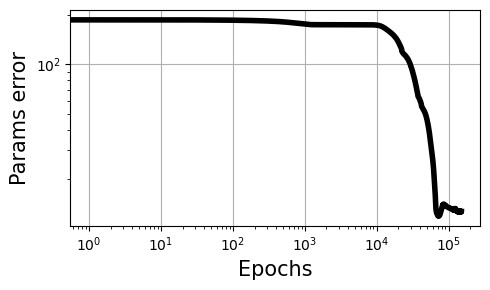

In [11]:
# Print and Plot R2 
# print(np.round(r2_store[-1],2))
print("r2 :","%.5g" % r2_store[-1])

plt.figure(figsize=(5,3))
plt.plot(r2_store, color = 'black',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Params error',fontsize=15)
plt.xscale('log')
plt.yscale('log')


plt.tight_layout()

fig_name = 'error_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_41340\2632352642.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges


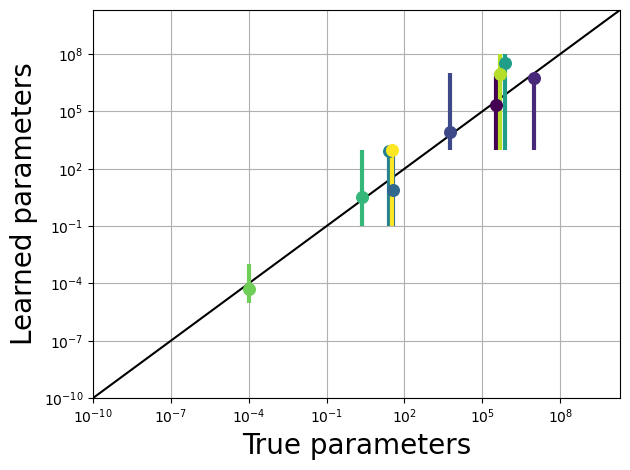

In [12]:
# Comparing parameters
learned_parameters=[pinn_cell.output_param_range(v,i).item() for (i,(k,v)) in enumerate(pinn_cell.ode_parameters.items())]
true_parameters=[DICT[key] for key in parameter_names]

plt.grid('true')
plt.plot([0, 2*10**10], [0, 2*10**10],color='black')
plt.scatter(true_parameters,learned_parameters)
plt.xscale('log')
plt.yscale('log')

cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges

# Map each range index to a color from the colormap
colors = [cmap(i) for i in range(len(ranges))]


for i, (true_val, learned_val) in enumerate(zip(true_parameters, learned_parameters)):
    plt.scatter(true_val, learned_val, s=70, color=colors[i], label=f'Range {i}' if i == 0 else "",zorder=3)

    # Also color the corresponding vertical line
    plt.vlines(x=true_val, ymin=ranges[i][0], ymax=ranges[i][1], colors=colors[i],zorder=2,linewidth=3)


min_value = min(r[0] for r in ranges)
max_value = max(r[1] for r in ranges)
plt.ylim([10**(-10),2*10**10])
plt.xlim([10**(-10),2*10**10])

plt.xlabel('True parameters',fontsize=20)
plt.ylabel('Learned parameters',fontsize=20)

plt.tight_layout()

fig_name = 'params_short'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

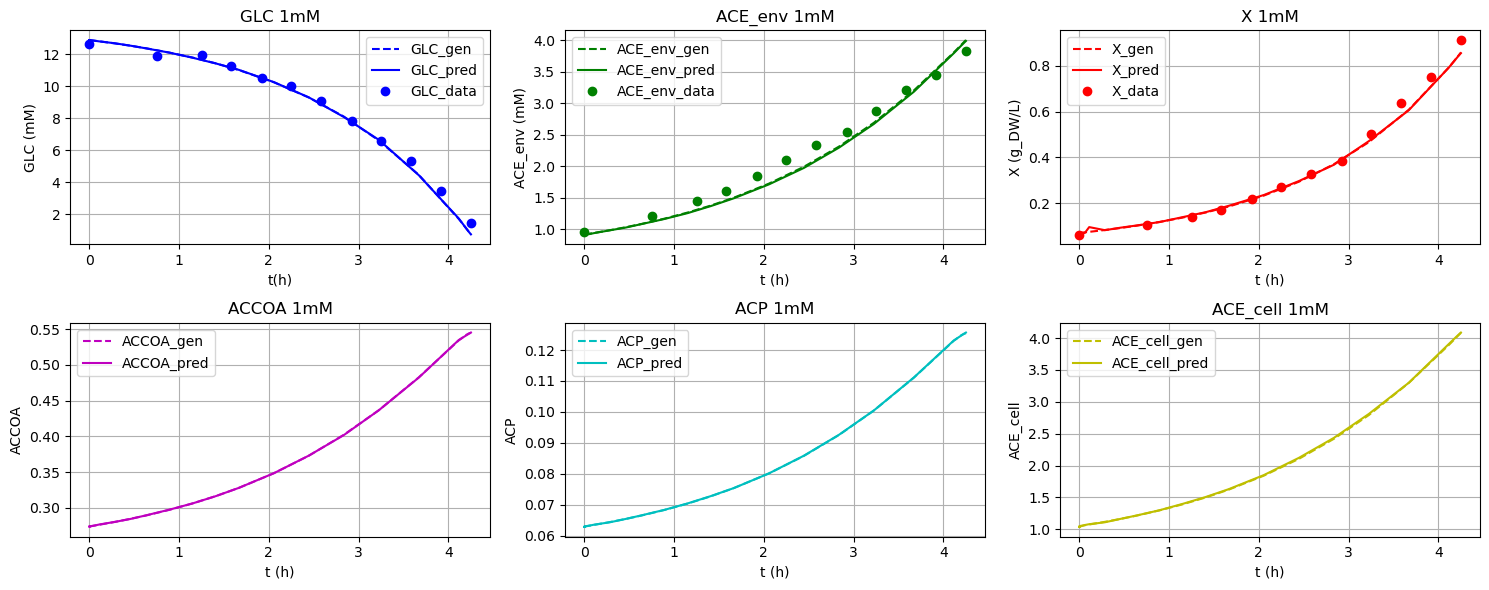

In [13]:
# Plot the predicted variables
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(res.t, GLC, linestyle='dashed', label='GLC_gen', color='b')
axs[0,0].plot(data_t, GLC_pred.detach().numpy(), label='GLC_pred', color='b')
axs[0,0].plot(data_1[1:, 0], data_1[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t(h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(res.t, ACE_env, linestyle='dashed', label='ACE_env_gen', color='g')
axs[0,1].plot(data_t, ACE_env_pred.detach().numpy(), label='ACE_env_pred', color='g')
axs[0,1].plot(data_1[1:, 0]  , data_1[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(res.t, X, linestyle='dashed', label='X_gen', color='r')
axs[0,2].plot(data_t, X_pred.detach().numpy(), label='X_pred', color='r')
axs[0,2].plot(data_1[1:, 0]  , data_1[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(res.t, ACCOA, linestyle='dashed', label='ACCOA_gen', color='m')
axs[1,0].plot(data_t, ACCOA_pred.detach().numpy(), label='ACCOA_pred', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(res.t, ACP, linestyle='dashed', label='ACP_gen', color='c')
axs[1,1].plot(data_t, ACP_pred.detach().numpy(), label='ACP_pred', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(res.t, ACE_cell, linestyle='dashed', label='ACE_cell_gen', color='y')
axs[1,2].plot(data_t, ACE_cell_pred.detach().numpy(), label='ACE_cell_pred', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

## Reconstruct values with learned parameters

In [14]:
# Integrate the Millard's model equations over the time grid
learned = DICT.copy()
learned = learned | dict(zip(parameter_names, learned_parameters))

net_res = solve_ivp(fun=deriv_Millard,
                t_span=(0,4.25),
                y0=y_1_0,
                method='LSODA',
                args=(learned,),
                t_eval=data_t,
                dense_output=True)

GLC_learned, ACE_env_learned, X_learned, ACCOA_learned, ACP_learned, ACE_cell_learned = net_res.y

variable_res = {"GLC":GLC_learned, "ACE_env":ACE_env_learned, "X":X_learned, "ACCOA":ACCOA_learned, "ACP":ACP_learned, "ACE_cell":ACE_cell_learned}

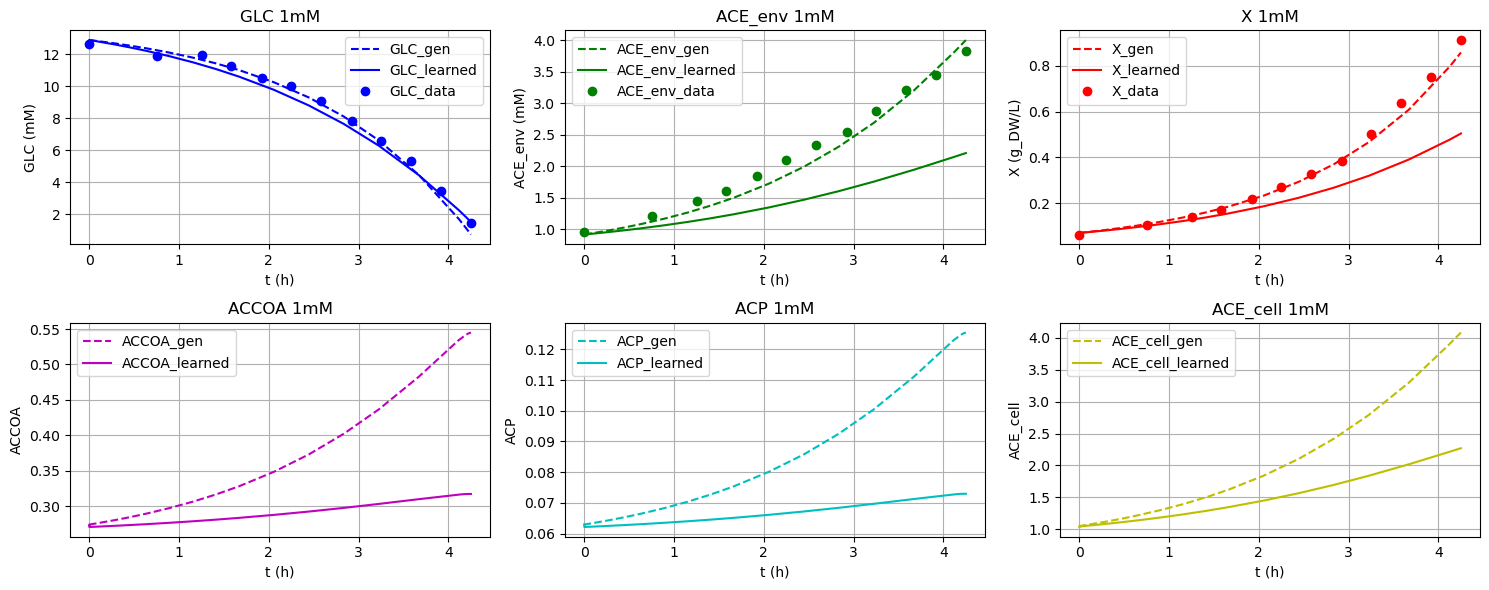

Sum of squared residuals error: 948.7478285716186


In [15]:
# Plot the solved variables
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0,0].plot(res.t, GLC, linestyle='dashed', label='GLC_gen', color='b')
axs[0,0].plot(net_res.t, GLC_learned, label='GLC_learned', color='b')
axs[0,0].plot(data_1[1:, 0], data_1[1:, 3], 'o', label='GLC_data', color='b')
axs[0,0].set_title('GLC 1mM')
axs[0,0].set_xlabel('t (h)')
axs[0,0].set_ylabel('GLC (mM)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].plot(res.t, ACE_env, linestyle='dashed', label='ACE_env_gen', color='g')
axs[0,1].plot(net_res.t, ACE_env_learned, label='ACE_env_learned', color='g')
axs[0,1].plot(data_1[1:, 0], data_1[1:, 1], 'o', label='ACE_env_data', color='g')
axs[0,1].set_title('ACE_env 1mM')
axs[0,1].set_xlabel('t (h)')
axs[0,1].set_ylabel('ACE_env (mM)')
axs[0,1].legend()
axs[0,1].grid(True)

axs[0,2].plot(res.t, X, linestyle='dashed', label='X_gen', color='r')
axs[0,2].plot(net_res.t, X_learned,label='X_learned', color='r')
axs[0,2].plot(data_1[1:, 0], data_1[1:, 2], 'o',label='X_data', color='r')
axs[0,2].set_title('X 1mM')
axs[0,2].set_xlabel('t (h)')
axs[0,2].set_ylabel('X (g_DW/L)')
axs[0,2].legend()
axs[0,2].grid(True)

axs[1,0].plot(res.t, ACCOA, linestyle='dashed', label='ACCOA_gen', color='m')
axs[1,0].plot(net_res.t, ACCOA_learned, label='ACCOA_learned', color='m')
axs[1,0].set_title('ACCOA 1mM')
axs[1,0].set_xlabel('t (h)')
axs[1,0].set_ylabel('ACCOA')
axs[1,0].legend()
axs[1,0].grid(True)

axs[1,1].plot(res.t, ACP, linestyle='dashed', label='ACP_gen', color='c')
axs[1,1].plot(net_res.t, ACP_learned, label='ACP_learned', color='c')
axs[1,1].set_title('ACP 1mM')
axs[1,1].set_xlabel('t (h)')
axs[1,1].set_ylabel('ACP')
axs[1,1].legend()
axs[1,1].grid(True)

axs[1,2].plot(res.t, ACE_cell, linestyle='dashed', label='ACE_cell_gen', color='y')
axs[1,2].plot(net_res.t, ACE_cell_learned, label='ACE_cell_learned', color='y')
axs[1,2].set_title('ACE_cell 1mM')
axs[1,2].set_xlabel('t (h)')
axs[1,2].set_ylabel('ACE_cell')
axs[1,2].legend()
axs[1,2].grid(True)

plt.tight_layout()
plt.show()

error = ssr_error(standard_deviations_dict=standard_deviations_dict, observables=observables, variable_data=variable_data, variable_res=variable_res)
print("Sum of squared residuals error: " + str(error))

In [16]:
# Print and compare parameters
from tools import param_error_percentages

print("Learned parameters :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", learned_parameters[i])

print()

print("True parameters :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", true_parameters[i])

print()

print("Parameters errors :")
for i in range(len(learned_parameters)):
    print(parameter_names[i], ":", param_error_percentages(true_parameters,learned_parameters)[i])



Learned parameters :
v_max_AckA : 210607.984375
v_max_Pta : 5649988.0
v_max_glycolysis : 8318.71875
Ki_ACE_glycolysis : 7.2418293952941895
Km_ACCOA_TCA_cycle : 811.39208984375
v_max_TCA_cycle : 35410516.0
Ki_ACE_TCA_cycle : 3.2998831272125244
Y : 5.242617771727964e-05
v_max_acetate_exchange : 8555483.0
Km_ACE_acetate_exchange : 965.4989624023438

True parameters :
v_max_AckA : 336940.01763224584
v_max_Pta : 9565521.763455136
v_max_glycolysis : 5557.64
Ki_ACE_glycolysis : 36.6776
Km_ACCOA_TCA_cycle : 24.759179607035055
v_max_TCA_cycle : 740859.8734990103
Ki_ACE_TCA_cycle : 2.3261654310710522
Y : 9.980425734506176e-05
v_max_acetate_exchange : 480034.5536336427
Km_ACE_acetate_exchange : 33.15358053265956

Parameters errors :
v_max_AckA : 0.3749392373901141
v_max_Pta : 0.4093382316492495
v_max_glycolysis : 0.496807772723674
Ki_ACE_glycolysis : 0.8025544366236016
Km_ACCOA_TCA_cycle : 31.771364105020734
v_max_TCA_cycle : 46.796509524479326
Ki_ACE_TCA_cycle : 0.41859348571487315
Y : 0.4747100

## Analyzing results

In [17]:
import pandas as pd
import csv

hyperparameters = {
    "epochs":epoch_number,
    "optimizer":str(optimizer_type),
    "optimizer_hyperparameters":str(optimizer_hyperparameters),
    "scheduler":str(scheduler_hyperparameters),
    "multiple_loss_method":multiple_loss_method,
    "ssr_error":error,
    "parameter_names": str(parameter_names),
    "SoftAdapt_beta":pinn_cell.SoftAdapt_beta,
    "SoftAdapt_t":pinn_cell.SoftAdapt_t,
    "residual_weights":str(pinn_cell.residual_weights),
    "variable_fit_weights":str(pinn_cell.variable_fit_weights),
    "prior_losses_t":pinn_cell.prior_losses_t,
}

# Saving results
fieldnames = ["epochs",
              "optimizer",
              "optimizer_hyperparameters",
              "scheduler",
              "multiple_loss_method",
              "ssr_error",
              "parameter_names",
              "SoftAdapt_beta",
              "SoftAdapt_t",
              "residual_weights",
              "variable_fit_weights",
              "prior_losses_t",]

with open('raw_toy_results_data.csv', mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow(hyperparameters)